In [5]:
pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn catboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('C:/Users/123/Desktop/intens2/train.csv', low_memory=False).drop_duplicates() 
df_validate = pd.read_csv('C:/Users/123/Desktop/intens2/valid.csv', low_memory=False).drop_duplicates() 
# low_memory параметр выключен, чтобы не отображать ошибки, связанные с тем, что в колонках содержаться несколько типов данных


In [8]:

df.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


In [9]:
df_validate.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4941670.0,4941670.0,4941670.0,NaN,NaN,NaN,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11789500.0,11789500.0,11789500.0,NaN,NaN,NaN,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7000000.0,7000000.0,7000000.0,NaN,NaN,NaN,7000000.0,7000000.0,7000000.0,0.257217
3,2023-03-01,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
4,2023-03-01,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10391000.0,10391000.0,10391000.0,0.257348


In [10]:
# Вывод размера
print(df.shape)
print(df_validate.shape)

(14456, 2666)
(3642, 2666)


Предобработка данных

In [11]:
# Функция для определения дубликатов столбцов
def identify_duplicate_columns(df):
    duplicates = {}
    for column in df.columns:
        # Преобразование столбцов в строку для сравнения
        col_contents = df[column].fillna('').astype(str).values
        col_contents.sort()
        encoding = hash(tuple(col_contents))
        if encoding in duplicates:
            duplicates[encoding].append(column)
        else:
            duplicates[encoding] = [column]
    return duplicates

duplicate_columns = identify_duplicate_columns(df)

columns_to_remove = []
for duplicate_set in duplicate_columns.values():
    if len(duplicate_set) > 1:
        # Оставляю первый столбец , остальные удаляю
        columns_to_remove.extend(duplicate_set[1:])

print(f"Исходное количество столбцов: {df.shape[1]}")

# Удаляем дубликаты столбцов
df = df.drop(columns=columns_to_remove)
df_validate = df_validate.drop(columns=columns_to_remove)

print(f"Количество удаленных столбцов: {len(columns_to_remove)}")
print(f"Количество оставшихся столбцов: {df.shape[1]}")

Исходное количество столбцов: 2666
Количество удаленных столбцов: 456
Количество оставшихся столбцов: 2210


Убираю колонки которые содержат 80% NaN

In [12]:
# дроп колонок по трешхолду
def drop_columns_with_nan(df, threshold_percent):
  nan_percentages = df.isnull().mean() * 100

  columns_to_drop = nan_percentages[nan_percentages > threshold_percent].index.tolist()
  print(f"Найдено {len(columns_to_drop)} колонок с NaN значениями больше чем {threshold_percent}%")
  return columns_to_drop

threshold = 80
columns_to_drop = drop_columns_with_nan(df, threshold)
df = df.drop(columns=columns_to_drop)
df_validate = df_validate.drop(columns=columns_to_drop)

Найдено 1901 колонок с NaN значениями больше чем 80%


In [13]:
# Функция для проверки наличия смешанных типов данных в столбце
def has_mixed_types(column):
    return column.apply(type).nunique() > 1

# Применение функции ко всем столбцам
mixed_type_columns = df.columns[df.apply(has_mixed_types)]

print("Столбцы со смешанным типом данных:")
print(mixed_type_columns.tolist())

Столбцы со смешанным типом данных:
['col1454']


In [14]:
df['col1454'].unique().tolist()

['00f3d719-a6ec-4960-ba01-8372eb705443',
 '01febac0-b083-494e-8589-f98400074b94',
 '0278175e-c0bb-4e1e-bfe5-20db6811d3e2',
 '0364571d-5325-ed11-b823-005056b825cd',
 '065957a6-9b2a-435a-b561-024e9e8d9ad7',
 '07ca8162-5b7d-ed11-b824-005056b89b68',
 '0a154951-7e02-47d2-8d3d-480d0c84c206',
 '0aed31ac-cbe2-42cb-af39-8470ad01e8a4',
 '0b08a6bb-42f5-ec11-b822-005056b8a6d9',
 '0b498e8a-7c01-466d-b112-0c5785574f45',
 '0c6cc76e-bd09-4eec-b4c8-4ef642923b06',
 '0d4ec1c7-914f-ed11-b824-005056b89b68',
 '0d92e8bb-7312-ed11-b824-005056b89b68',
 '0ed64779-4334-4018-8b29-8ac3ad4353e0',
 '0f4a91d4-23f6-4745-9461-60d5cbf276ba',
 '0fe93355-5c69-455c-b7f5-b29f4b4db275',
 '101472b3-875b-428d-bcc2-21a30f13f124',
 '1071b34a-8ae6-40cf-96f2-328155d43be4',
 '12285d31-e47f-4044-b18a-6e590188fcf2',
 '13518128-3ebd-4b5f-9bdd-9220048a60de',
 '1361f472-a35e-4eb1-af5d-3308b40bcc3a',
 '1464db6a-d629-ed11-b824-005056b89b68',
 '15ce3286-7a62-ed11-b822-005056b8a6c4',
 '169e0338-95c5-4ab5-b94b-d7a55c501214',
 '16c5c669-adb2-

In [15]:
df = df.drop(columns=['col1454'])
df_validate = df_validate.drop(columns=['col1454'])

In [16]:
# проверяю, одинаково ли удаляются колонки по обоим датасетам
print(df.shape)
print(df_validate.shape)

(14456, 308)
(3642, 308)


Заполнение NaN

<Axes: >

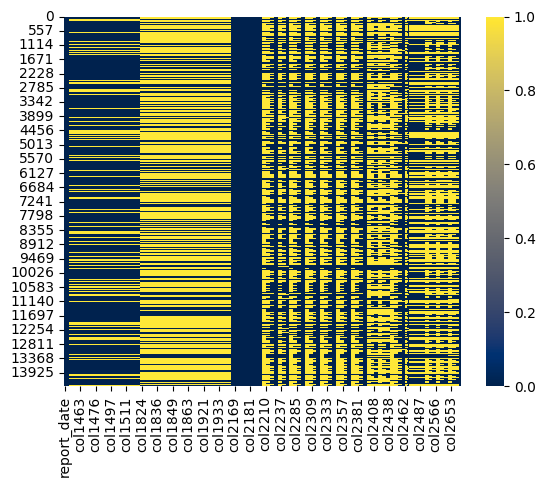

In [17]:
# Вывод тепловой карты для понимая количества NaN
sns.heatmap(df.isnull(),cmap='cividis')

Метод KNNImputer - Заполняет на основе ближайших соседей

<Axes: >

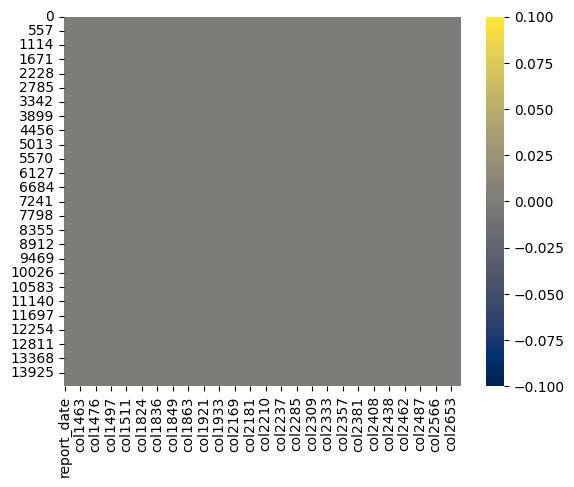

In [18]:
from sklearn.impute import KNNImputer

df_numeric = df.drop(columns=['report_date', 'client_id'])
df_validate_numeric = df_validate.drop(columns=['report_date', 'client_id'])

imputer = KNNImputer(n_neighbors=5)

df_imputed = imputer.fit_transform(df_numeric)
df_validate_imputed = imputer.transform(df_validate_numeric)

df_numeric = pd.DataFrame(df_imputed, columns=df_numeric.columns)
df_validate_numeric = pd.DataFrame(df_validate_imputed, columns=df_validate_numeric.columns)

df = pd.concat([df[['report_date', 'client_id']], df_numeric], axis=1)
df_validate = pd.concat([df_validate[['report_date', 'client_id']], df_validate_numeric], axis=1)

sns.heatmap(df.isnull(), cmap='cividis')

после заполнения пустых значений разделяем данные на 3 выборки - на которой будет обучаться модель, и 2 выборки для проверки - первая из того же датасета, на котором модель будет обучаться, а вторая - которую модель до этого не видела, что позволит отслеживать переобучение и получить более правдивые оценки по метрике.

In [19]:
# разделим фичи и таргет
from sklearn.model_selection import train_test_split

# Разделение данных на признаки и целевую переменную
X = df.drop(['report_date', 'client_id', 'target'], axis=1)
y = df['target']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Вывод размеров полученных выборок
print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

# Для тестовой выборки
X_valid = df_validate.drop(['report_date', 'client_id', 'target'], axis=1)
y_valid = df_validate['target']
print("Размер валидационной выборки:", X_valid.shape)

Размер обучающей выборки: (11564, 305)
Размер тестовой выборки: (2892, 305)
Размер валидационной выборки: (3642, 305)


In [20]:
# кодируем категориальные колонки с помощью OrdinalEncoder 
from sklearn.preprocessing import OrdinalEncoder

def encoding_data(selection):
  ordinal_encoder = OrdinalEncoder()
  
  categorical_columns = selection.select_dtypes(include=['object']).columns.tolist()
  selection[categorical_columns] = selection[categorical_columns].astype(str)

  encoded_data = ordinal_encoder.fit_transform(selection[categorical_columns])
  selection[categorical_columns] = encoded_data.astype(int)
  
  return selection
  


X_train = encoding_data(X_train)
X_test = encoding_data(X_test)
X_valid = encoding_data(X_valid)


Баланс классов с помощью Smote

Проверка баланса классов для целевой переменной

Баланс классов в обучающей выборке:
target
0.0    0.969474
1.0    0.030526
Name: proportion, dtype: float64


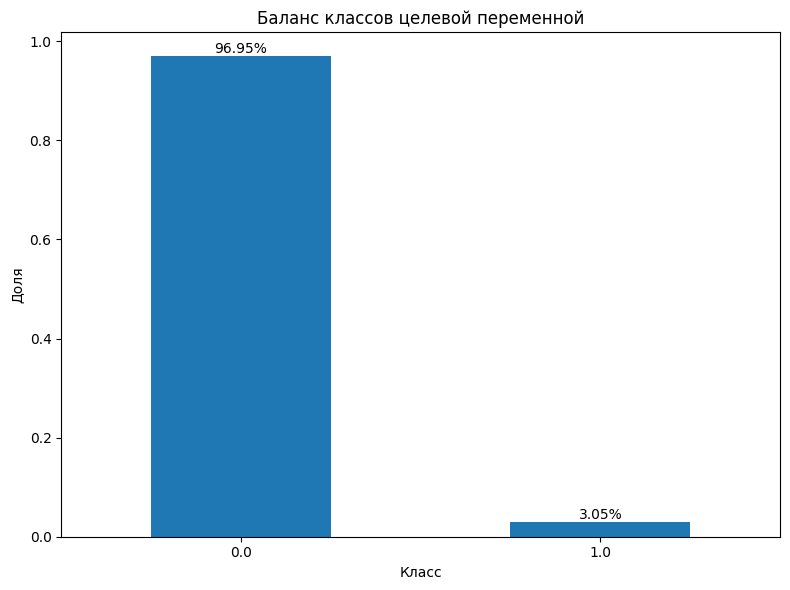


Абсолютные значения:
target
0.0    11211
1.0      353
Name: count, dtype: int64


In [21]:
# Вывод баланса классов для целевой переменной
class_balance = y_train.value_counts(normalize=True)
print("Баланс классов в обучающей выборке:")
print(class_balance)

# Визуализация баланса классов
plt.figure(figsize=(8, 6))
class_balance.plot(kind='bar')
plt.title('Баланс классов целевой переменной')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for i, v in enumerate(class_balance):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Вывод абсолютных значений
print("\nАбсолютные значения:")
print(y_train.value_counts())

Присутствует разница между классами. Исправление с помощью метода SMOTE, который генерирует синтетические данные на основе уже существующих для класса, который имеет меньшее содержание в датасете.

c:\Users\123\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\123\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\123\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\123\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\123

Баланс классов в сбалансированной обучающей выборке:
target
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


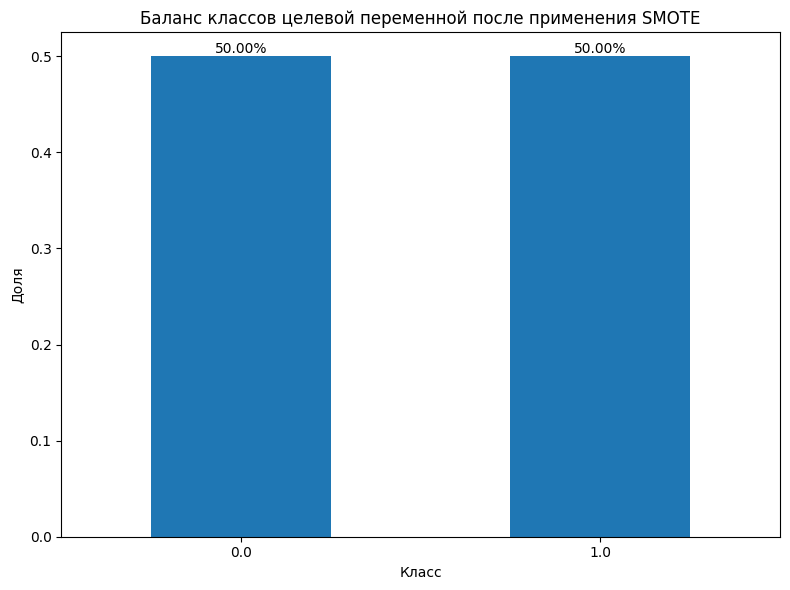

In [22]:
from imblearn.over_sampling import SMOTE

# Создание объекта SMOTE
smote = SMOTE(random_state=42)

# Применение SMOTE к обучающей выборке
X_train, y_train = smote.fit_resample(X_train, y_train)

# Проверка нового баланса классов
class_balance_balanced = y_train.value_counts(normalize=True)
print("Баланс классов в сбалансированной обучающей выборке:")
print(class_balance_balanced)

# Визуализация нового баланса классов
plt.figure(figsize=(8, 6))
class_balance_balanced.plot(kind='bar')
plt.title('Баланс классов целевой переменной после применения SMOTE')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for i, v in enumerate(class_balance_balanced):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

PCA

Метод PCA - Выбор главных признаков которые имеют большее влияние , позволяет уменьшить размер данных при этом сохранить как можно больше информации

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Выбор наиболее значимых признаков с помощью PCA
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])
X_valid_scaled = scaler.transform(X_valid[numerical_cols])

pca = PCA(n_components=0.92)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_valid_pca = pca.transform(X_valid_scaled)


print(f'Number of components: {pca.n_components_}')

Number of components: 66


Модели

In [24]:
# Импортирование методов для метрики ROC-AUC
from sklearn.metrics import roc_auc_score, roc_curve

ROC-AUC на тестовой выборке: 0.9310628058692584
ROC-AUC на валидационной выборке: 0.7815444715612501


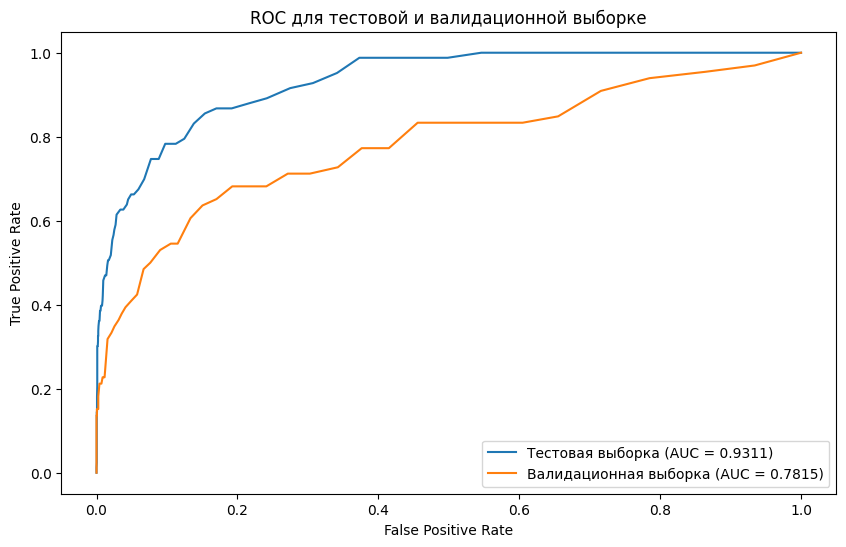

In [25]:
# модель RandomForestClassifier 100 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = rf.predict_proba(X_test_pca)[:, 1]
roc_auc_test_rf_100 = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_rf_100}')

# Построение ROC для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_rf_100:.4f})')

# Проверка на валидационной выборке
y_pred_proba_valid = rf.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_rf_100 = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_rf_100}')

# Построение ROC для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_rf_100:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC для тестовой и валидационной выборке')
plt.legend()
plt.show()

ROC на тестовой выборке: 0.9370633119877159
ROC на валидационной выборке: 0.7959523930580976


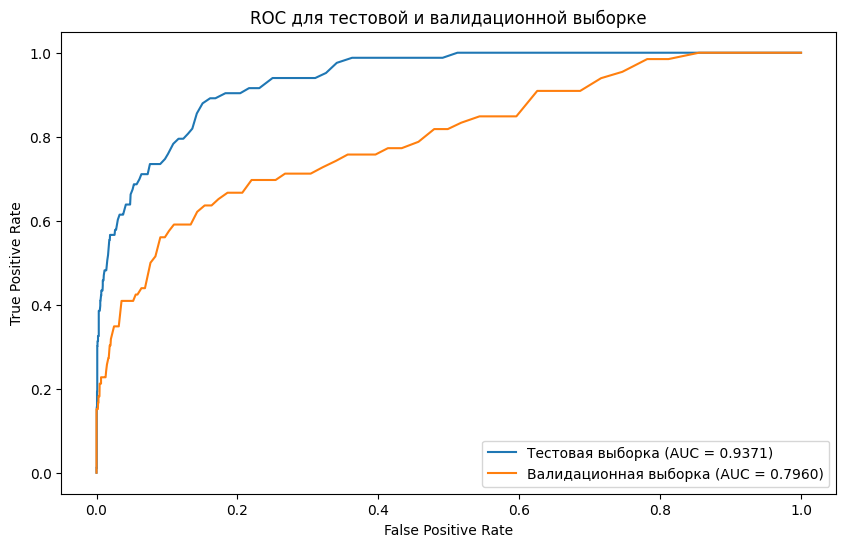

In [26]:
# модель RandomForestClassifier 200
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = rf.predict_proba(X_test_pca)[:, 1]
roc_auc_test_rf_200 = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC на тестовой выборке: {roc_auc_test_rf_200}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_rf_200:.4f})')

# Проверка на валидационной выборке
y_pred_proba_valid = rf.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_rf_200 = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC на валидационной выборке: {roc_auc_valid_rf_200}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_rf_200:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC для тестовой и валидационной выборке')
plt.legend()
plt.show()

ROC на тестовой выборке: 0.8644203013549393
ROC на валидационной выборке: 0.6755940275235578


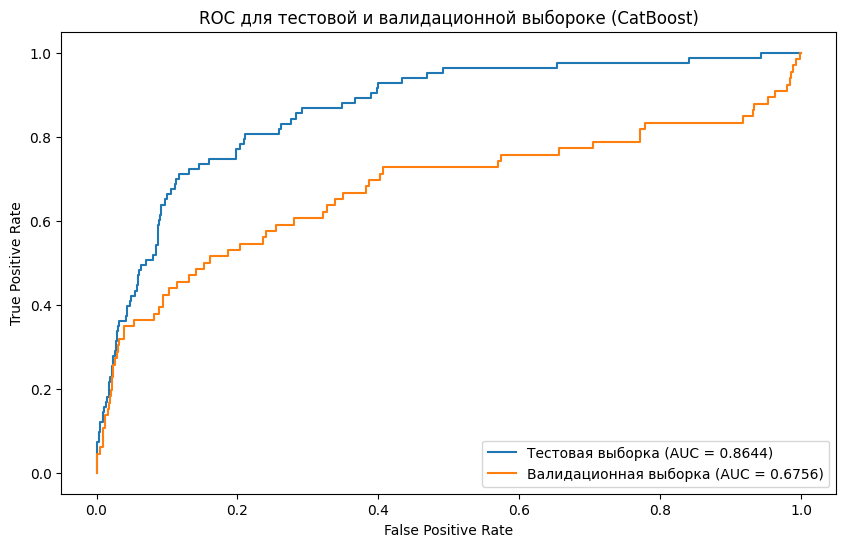

In [27]:
# модель CatBoost 
from catboost import CatBoostClassifier

# Создание и обучение модели CatBoost
model = CatBoostClassifier(iterations=1000, learning_rate=0.01, random_state=42, depth=5, verbose=False)
model.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = model.predict_proba(X_test_pca)[:, 1]
roc_auc_test_cb = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC на тестовой выборке: {roc_auc_test_cb}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_cb:.4f})')

# Проверка на валидационной выборке
y_pred_proba_valid = model.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_cb = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC на валидационной выборке: {roc_auc_valid_cb}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_cb:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC для тестовой и валидационной выбороке (CatBoost)')
plt.legend()
plt.show()

ROC на тестовой выборке: 0.787923498908414
ROC на валидационной выборке: 0.7529659006169074


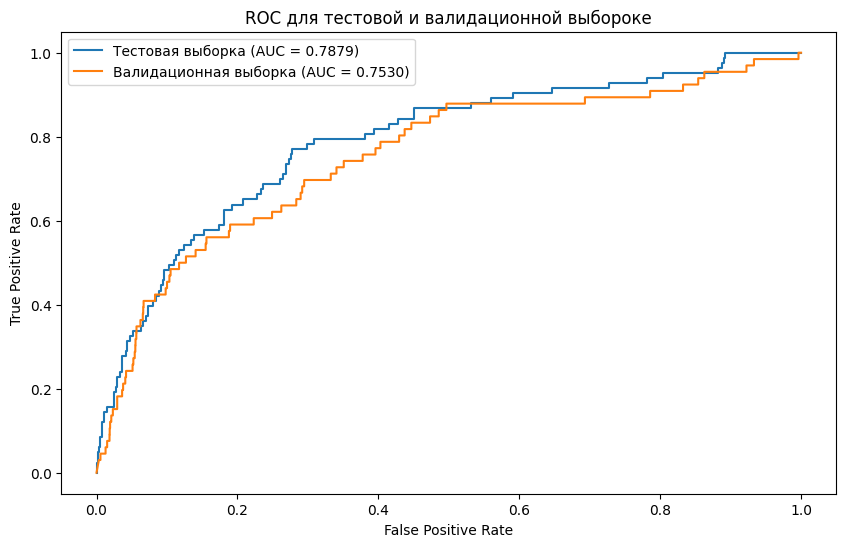

In [28]:
# модель LogisticRegression
from sklearn.linear_model import LogisticRegression

# Создание и обучение модели логистической регрессии с L1 регуляризацией
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
model.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = model.predict_proba(X_test_pca)[:, 1]
roc_auc_test_lr = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC на тестовой выборке: {roc_auc_test_lr}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_lr:.4f})')

# Проверка на валидационной выборке
y_pred_proba_valid = model.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_lr = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC на валидационной выборке: {roc_auc_valid_lr}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_lr:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC для тестовой и валидационной выбороке')
plt.legend()
plt.show()

Общие результаты моделей

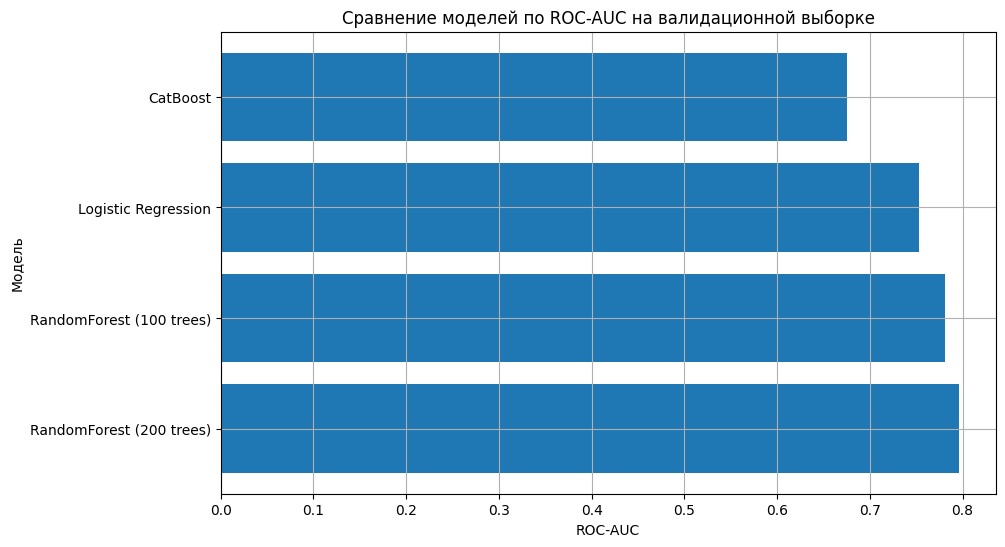

In [29]:
import matplotlib.pyplot as plt

# Значения AUC-ROC для валидационной выборки
roc_auc_values = [roc_auc_valid_rf_100, roc_auc_valid_rf_200, roc_auc_valid_lr, roc_auc_valid_cb]

# Названия моделей
model_names = ['RandomForest (100 trees)' , 'RandomForest (200 trees)', 'Logistic Regression', 'CatBoost']

# Сортировка значений AUC-ROC по убыванию
sorted_indices = sorted(range(len(roc_auc_values)), key=lambda k: roc_auc_values[k], reverse=True)
roc_auc_values = [roc_auc_values[i] for i in sorted_indices]
model_names = [model_names[i] for i in sorted_indices]

# Строим график
plt.figure(figsize=(10, 6))
plt.barh(range(len(roc_auc_values)), roc_auc_values, align='center')
plt.yticks(range(len(roc_auc_values)), model_names)
plt.xlabel('ROC-AUC')
plt.ylabel('Модель')
plt.title('Сравнение моделей по ROC-AUC на валидационной выборке')
plt.grid(True)
plt.show()

Итоговая модель

Исходя из оценок метрики AUC-ROC самой лучшей моделью оказалась RandomForest 200


In [30]:


# Создание датафрейма с идентификаторами клиентов и предсказаниями
submission_df = pd.DataFrame({
    'client_id': df_validate['client_id'],
    'target': y_pred_proba_valid
})

# Сохранение датафрейма с результатами в csv-файл
submission_df.to_csv('submission_file.csv', index=False)

print("Файл submission_file.csv сохранен.")




Файл submission_file.csv сохранен.
